Iteration 1, ||delta||= 3.029921e+02
Iteration 2, ||delta||= 4.463662e+05
Iteration 3, ||delta||= 4.803955e+05
Final local vol array sigma(K): [-1.00000060e+01 -4.85839577e+04  5.01617175e+04  9.50000000e+01
  1.20000000e+02  1.18000000e+02  1.15000000e+02  1.13000000e+02
  1.10000000e+02  1.08000000e+02  1.05000000e+02]


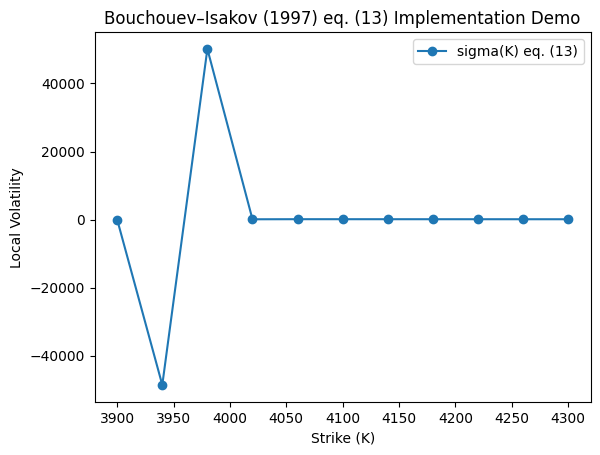

In [3]:
import numpy as np
import math
from math import log, exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
from scipy.integrate import dblquad


def build_strike_grid(K_min, K_max, n):
    """
    Build a uniform strike grid of n+1 points from K_min up to K_max.

    Specifically:
      - Step size: h = (K_max - K_min) / n
      - Grid points: K_i = K_min + (i-1)*h, for i=1..(n+1).

    Returns
    -------
    K_vals : numpy array
        The array of strike grid points of length (n+1).
    h : float
        The constant step size used to build the grid.
    """
    if n <= 0:
        raise ValueError("n must be a positive integer.")
    h = (K_max - K_min) / n
    K_vals = np.array([K_min + h * (i - 1) for i in range(1, n + 2)])
    return K_vals, h


# Seven-point rule on the standard triangle { (r,s): r>=0, s>=0, r+s<=1 }
tri_nodes_7 = np.array([
    [0.1012865073, 0.1012865073],
    [0.1012865073, 0.7974269853],
    [0.7974269853, 0.1012865073],
    [0.3333333333, 0.3333333333],
    [0.4701420641, 0.0597158718],
    [0.4701420641, 0.4701420641],
    [0.0597158718, 0.4701420641],
])

tri_weights_7 = np.array([
    0.1259391805,
    0.1259391805,
    0.1259391805,
    0.2250000000,
    0.1323941527,
    0.1323941527,
    0.1323941527
])

def bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta):
    """
    The bracket from eq. (12) in Bouchouev–Isakov (1997):
        ((sigma^2(nu) - sigma^2(K)) / 2zeta)
            * [ (ln(nu/K))^2 / (zeta sigma^2(K))  - 1 ]
      + ( sigma^2(nu)/2  - R + D ) * [ (ln(nu/K)) / zeta ]

    Here, tau and zeta appear as part of the domain integration, but
    the bracket formula uses only 'zeta' explicitly in the denominators.
    """
    s2Nu = sigmaNu**2
    s2K  = sigmaK**2

    partA = (s2Nu - s2K) / (2.0 * zeta)
    subA  = ( (ln_nuK**2) / (zeta * s2K) ) - 1.0
    item1 = partA * subA

    item2 = ((s2Nu / 2.0) - R + D) * (ln_nuK / zeta)
    return item1 + item2


# def I1_sigma_2DGauss(K, nu, x_star, T_minus,
#                      sigmaK, sigmaNu, R, D,
#                      tri_nodes=tri_nodes_7, tri_weights=tri_weights_7):
#     """
#     Compute I_sigma^{(1)}(K, nu) from eqn. (12) in Bouchouev–Isakov (1997).

#     We integrate over 0 <= zeta <= tau <= T_minus:
#        I1 = (K / [4 pi nu sigmaK sigmaNu]) *
#              ∫∫ [ bracket_expr(...) * exp(...) * exp(...) / sqrt((tau-zeta)*zeta) ]
#              d zeta d tau.

#     Implementation:
#       1) We do a transform from the reference triangle (r,s) with r>=0, s>=0, r+s<=1
#          to the domain 0 <= zeta <= tau <= T_minus via:
#              tau  = (r + s) * T_minus
#              zeta = r       * T_minus
#          The Jacobian is T_minus^2, but since tri_weights sum to 1 (not 1/2),
#          we multiply each integrand by 0.5 * T_minus^2.
#       2) We do a 7-point Dunavant rule on that reference triangle:
#          sum_i [ w_i * integrand(r_i, s_i) ].
#       3) We then multiply by the prefactor = K / [4 pi nu sigmaK sigmaNu].
#     """
#     # If either local vol is effectively zero, skip
#     if sigmaK < 1e-12 or sigmaNu < 1e-12:
#         return 0.0

#     # Factor outside the integral
#     factor = (K / (4.0 * pi * nu * sigmaK * sigmaNu))

#     # Precompute logs used inside the integrand
#     ln_nuK = math.log(nu / K)
#     ln_xnu = math.log(x_star / nu)

#     # We'll define a local helper to evaluate the integrand at (r, s).
#     def integrand(r, s):
#         # Map (r,s) -> (tau, zeta)
#         tau  = (r + s) * T_minus
#         zeta = r       * T_minus

#         # Because r>=0, s>=0, r+s<=1, we have 0 <= zeta <= tau <= T_minus
#         # Avoid dividing by zero
#         if tau <= 1e-15 or zeta <= 1e-15 or (tau - zeta) <= 1e-15:
#             return 0.0

#         # Evaluate bracket
#         bval = bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta)

#         # Exponential parts
#         #   exp1 = exp( - [ (ln(x*/nu))^2 ] / [ 2 * (tau - zeta) * sigmaNu^2 ] )
#         #   exp2 = exp( - [ (ln(nu/K))^2 ] / [ 2 * zeta * sigmaK^2 ] )
#         val_exp1 = math.exp( - (ln_xnu**2) / (2.0 * (tau - zeta) * (sigmaNu**2)) )
#         val_exp2 = math.exp( - (ln_nuK**2) / (2.0 * zeta * (sigmaK**2)) )

#         # sqrt((tau-zeta)*zeta) in the denominator
#         denom = math.sqrt((tau - zeta) * zeta)

#         return (bval * val_exp1 * val_exp2) / denom

#     # Accumulate over the 7 Dunavant points
#     accum = 0.0
#     # The factor for area scaling: domain is area = 1/2 in reference space,
#     # but the tri_weights sum to 1, so we multiply by 0.5 * T_minus^2:
#     J = 0.5 * (T_minus**2)

#     for (r_i, s_i), w_i in zip(tri_nodes, tri_weights):
#         val = integrand(r_i, s_i)
#         accum += w_i * val * J

#     return factor * accum

def I1_sigma_2DGauss(K, nu, x_star, T_minus_tstar, sigmaK, sigmaNu, R, D, nGauss=10):
    """
    Computes I_sigma^{(1)}(K, nu) using 2D Gaussian Quadrature for efficiency.
    """
    if sigmaK < 1e-12 or sigmaNu < 1e-12:
        return 0.0

    # Prefactor
    factor = (K / (4.0 * np.pi * nu * sigmaK * sigmaNu))
    ln_nuK = math.log(nu / K)
    ln_xnu = math.log(x_star / nu)
    
    # Avoid singularities by using a small epsilon
    epsilon = 1e-8

    # Gauss-Legendre nodes and weights for 2D integration
    nodes, weights = roots_legendre(nGauss)

    def transform_to_tau_zeta(r, s):
        """ Transform from [-1,1] to [0, T_minus_tstar] for tau and zeta """
        tau = 0.5 * (r + 1) * T_minus_tstar  # Map r from [-1,1] to [0, T_minus_tstar]
        zeta = 0.5 * (s + 1) * tau  # Map s from [-1,1] to [0, tau]
        return tau, zeta

    def integrand(r, s):
        tau, zeta = transform_to_tau_zeta(r, s)
        if tau <= epsilon or zeta <= epsilon or (tau - zeta) <= epsilon:
            return 0.0

        # Compute bracket term
        bracket_term = ((sigmaNu**2 - sigmaK**2) / (2.0 * zeta)) * \
                       ((ln_nuK**2) / (zeta * sigmaK**2) - 1.0) \
                       + ((sigmaNu**2 / 2.0) - R + D) * (ln_nuK / zeta)

        # Compute exponentials
        exp1 = np.exp(np.clip(- (ln_xnu**2) / (2.0 * (tau - zeta) * sigmaNu**2), -100, 100))
        exp2 = np.exp(np.clip(- (ln_nuK**2) / (2.0 * zeta * sigmaK**2), -100, 100))

        # Compute denominator with epsilon to avoid zero division
        denom = math.sqrt((tau - zeta + epsilon) * (zeta + epsilon))

        return (bracket_term * exp1 * exp2) / denom

    # Compute the 2D Gaussian quadrature sum
    integral_sum = 0.0
    for i in range(nGauss):
        for j in range(nGauss):
            r_i, s_j = nodes[i], nodes[j]
            w_i, w_j = weights[i], weights[j]
            integral_sum += w_i * w_j * integrand(r_i, s_j)

    # Scaling factor for the transformation of limits
    J = (0.5 * T_minus_tstar) * (0.5 * T_minus_tstar)

    return factor * integral_sum * J


def I2_sigma_1DGauss(K, nu, x_star, T_minus, sigma_nu, R, D, nGauss=10):
    """
    Compute I_sigma^{(2)}(K, nu) from equation (12) in Bouchouev–Isakov (1997).

    That term looks like:
        I2 = [ 2 / ( sqrt(2*pi) * sigma(nu)^2 ) ] * [ (R*K/nu) - D ]
             * ∫_{0}^{sigma(nu)*sqrt(T_minus)} exp( - [ln(x_star/nu)^2]/[2*s^2] ) ds.

    Parameters
    ----------
    K : float
        The strike K in the integral I_sigma^{(2)}(K, nu).
    nu : float
        The 'nu' argument in I_sigma^{(2)}(K, nu).
    x_star : float
        Underlying price (S or x* in the paper).
    T_minus : float
        T_minus_tstar = (T - t*), i.e. time to maturity.
    sigma_nu : float
        The local volatility sigma(nu).
    R : float
        Risk-free rate.
    D : float
        Continuous dividend yield (or foreign rate in FX context).
    nGauss : int, optional
        Number of Gauss–Legendre nodes. Default is 10.

    Returns
    -------
    float
        The numerical approximation of I_sigma^{(2)}(K, nu).

    Notes
    -----
    1) If sigma(nu) is extremely small, or the computed sMax is tiny, the integral
       is effectively zero.
    2) Uses Gauss–Legendre quadrature on [0, sMax], with a standard transformation
       from [-1,1] -> [0, sMax].
    """
    # Safeguard against near-zero vol:
    if sigma_nu < 1e-12:
        return 0.0

    # Prefactor outside the integral:
    factor = (2.0 / (math.sqrt(2.0 * pi) * sigma_nu**2)) * ((R * K / nu) - D)

    # Upper limit of integration:
    sMax = sigma_nu * math.sqrt(T_minus)
    if sMax <= 1e-12:
        return 0.0

    # Precompute the log-term:
    ln_xnu = math.log(x_star / nu)

    # The function we integrate over s in [0, sMax].
    def integrand(s):
        # The integrand is e^{- [ (ln_xnu)^2 / (2 s^2) ] }, for s > 0.
        if s <= 1e-15:
            return 0.0
        exponent = - (ln_xnu**2) / (2.0 * s**2)
        return math.exp(exponent)

    # Gauss–Legendre nodes and weights on [-1, +1].
    nodes, weights = roots_legendre(nGauss)

    # We'll map from [-1, +1] to [0, sMax] as:
    #   s = (sMax/2) * (r + 1)
    #   ds = (sMax/2)
    half_range = 0.5 * sMax

    accum = 0.0
    for i in range(nGauss):
        # Map node from [-1,1] to [0, sMax]
        r_i = nodes[i]          # in [-1,1]
        s_i = half_range * (r_i + 1.0)
        w_i = weights[i]        # weight for the node r_i

        f_i = integrand(s_i)
        accum += w_i * f_i

    # Multiply the raw quadrature sum by the scale for ds
    # (which is half_range = sMax/2).
    integral_approx = accum * half_range

    return factor * integral_approx


def update_sigma_eq13(
    i,
    sigma_m,
    K_vals,
    h,
    R,
    D,
    x_star,
    T_minus,
    uStar_vals,
    I1_2DGauss_func,
    I2_1DGauss_func
):
    """
    Compute the updated local volatility sigma^{(m+1)}(K_i) using equation (13)
    of Bouchouev–Isakov (1997), discretized with the trapezoid rule.

    Parameters
    ----------
    i : int
        1-based index in [1..n+1].
    sigma_m : array-like, shape (n+1,)
        The local vol array from the previous iteration, i.e. sigma^(m)(K_j).
    K_vals : array-like, shape (n+1,)
        The uniform strike grid K_1..K_{n+1}.
    h : float
        The grid step size, (K_{max} - K_{min}) / n.
    R : float
        Risk-free interest rate.
    D : float
        Continuous dividend yield.
    x_star : float
        Underlying price (S or x* in the paper).
    T_minus : float
        T_minus_tstar = T - t*, time to maturity from the current time.
    uStar_vals : array-like, shape (n+1,)
        Market call prices at the grid strikes, i.e. u_*(K_i).
    I1_2DGauss_func : callable
        Function to compute the 2D integral I_sigma^{(1)}(K_i, K_j).
        Must have signature like:
          I1_2DGauss_func(Ki, Kj, x_star, T_minus, sigmaKi, sigmaKj, R, D)
    I2_1DGauss_func : callable
        Function to compute the 1D integral I_sigma^{(2)}(K_i, K_j).
        Must have signature like:
          I2_1DGauss_func(Ki, Kj, x_star, T_minus, sigmaKj, R, D)

    Returns
    -------
    float
        The newly computed local volatility sigma^{(m+1)}(K_i).
    """
    n = len(K_vals) - 1  # Because we have n+1 grid points
    idx = i - 1          # Convert to 0-based
    K_i = K_vals[idx]

    # Leading term: market call price minus intrinsic value
    sigma_next_i = uStar_vals[idx] - max(0.0, x_star - K_i)

    #----------------------------------------------------------------------
    # 1) Approximate the integral term for I_sigma^{(1)} from K=0..∞
    #    using trapezoid on K_1..K_{n+1} with step h.
    #    -> eqn (13) lumps them into  " - h * sum_{j=2..n} - (h/2)* ... boundary"
    #----------------------------------------------------------------------
    I1_accum = 0.0
    # (a) interior j=2..n
    for j in range(1, n):  # python => 1..(n-1) => K2..K_n
        K_j = K_vals[j]
        # We use sigma^(m)(K_i) and sigma^(m)(K_j)
        sK_i = sigma_m[idx]
        sK_j = sigma_m[j]
        val_i1 = I1_2DGauss_func(K_i, K_j, x_star, T_minus, sK_i, sK_j, R, D)
        I1_accum += val_i1

    # (b) boundary j=1 => K1, j=n+1 => K_{n+1}
    sK_i = sigma_m[idx]
    sK_1 = sigma_m[0]
    i1_K1 = I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus, sK_i, sK_1, R, D)

    sK_n1 = sigma_m[n]
    i1_Kn1 = I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus, sK_i, sK_n1, R, D)

    # Subtract them with trapezoidal weighting
    sigma_next_i -= h * I1_accum
    sigma_next_i -= 0.5 * h * (i1_K1 + i1_Kn1)

    #----------------------------------------------------------------------
    # 2) Approximate the integral term for I_sigma^{(2)} from K_i..∞
    #    i.e. from j=i..n+1 in the discrete sense
    #    -> eqn (13) lumps them into " - h sum_{j=i+1..n} - (h/2)* ... boundary"
    #----------------------------------------------------------------------
    I2_accum = 0.0
    # (a) interior j=i+1..n
    for j in range(i, n):  # python => i..(n-1) => K_{i+1}..K_n
        K_j = K_vals[j]
        sK_j = sigma_m[j]
        val_i2 = I2_1DGauss_func(K_i, K_j, x_star, T_minus, sK_j, R, D)
        I2_accum += val_i2

    # (b) boundary => j=i => K_i, j=n+1 => K_{n+1}
    i2_left = I2_1DGauss_func(K_i, K_i, x_star, T_minus, sigma_m[idx], R, D)
    i2_right= I2_1DGauss_func(K_i, K_vals[n], x_star, T_minus, sigma_m[n], R, D)

    sigma_next_i -= h * I2_accum
    sigma_next_i -= 0.5 * h * (i2_left + i2_right)

    return sigma_next_i


def solve_local_vol_BI_equation13(
    K_vals,
    h,
    R,
    D,
    x_star,
    T_minus,
    uStar_vals,
    sigma_init,
    I1_2DGauss_func,
    I2_1DGauss_func,
    max_iter=5,
    tol=1e-5
):
    """
    Solve for the local volatility {sigma(K_i)} via the Bouchouev–Isakov (1997)
    iterative scheme from their equation (13).

    Parameters
    ----------
    K_vals : array-like, shape (n+1,)
        The uniform grid of strikes K_1..K_{n+1}.
    h : float
        The strike step size.
    R : float
        Risk-free interest rate.
    D : float
        Continuous dividend yield.
    x_star : float
        Underlying price (S).
    T_minus : float
        Time to maturity (T - t*).
    uStar_vals : array-like, shape (n+1,)
        The market call prices u_*(K_i).
    sigma_init : array-like, shape (n+1,)
        An initial guess for the local volatility at each grid point.
    I1_2DGauss_func : callable
        Function implementing the 2D integral I_sigma^{(1)}(K_i,K_j).
    I2_1DGauss_func : callable
        Function implementing the 1D integral I_sigma^{(2)}(K_i,K_j).
    max_iter : int, optional
        Maximum number of iteration steps. Default is 5.
    tol : float, optional
        Convergence tolerance on the Euclidean norm of the change in sigma.
        Default is 1e-5.

    Returns
    -------
    numpy.ndarray
        The final array of local volatilities, sigma^(m+1)(K_j),
        after either converging or hitting max_iter.

    Notes
    -----
    - We do the usual fixed-point iteration:
         sigma_{m+1}(K_i) = eqn(13).
    - After each iteration we compute ||sigma_new - sigma_old||_2 to check
      convergence. If it is below 'tol', we terminate early.
    - In a real-world setting, you might want regularization or smoothing
      for noisy data or a finer grid.
    """
    sigma_old = sigma_init.copy()
    n = len(K_vals) - 1

    for iteration in range(max_iter):
        sigma_new = np.zeros_like(sigma_old)
        # Update each K_i in 1..n+1
        for i in range(1, n+2):
            sigma_new[i - 1] = update_sigma_eq13(
                i,
                sigma_old,
                K_vals,
                h,
                R,
                D,
                x_star,
                T_minus,
                uStar_vals,
                I1_2DGauss_func,
                I2_1DGauss_func
            )

        # Check change from old iteration
        diffnorm = np.linalg.norm(sigma_new - sigma_old)
        print(f"Iteration {iteration+1}, ||delta|| = {diffnorm:.6e}")

        sigma_old = sigma_new
        if diffnorm < tol:
            print(f"Converged after {iteration+1} iterations.")
            break

    return sigma_old

# ---------------------------------------------------------------------
#  Demo main
# ---------------------------------------------------------------------
if __name__ == "__main__":

    # 1) Build a small uniform grid of n+1 = 5 strike points
    K_min, K_max = 3900.0, 4300.0
    # n = 4  # So the step is h = 100 => K_1..K_5
    # K_vals, h = build_strike_grid(K_min, K_max, n)
    # print("Strike grid:", K_vals, "step h =", h)

    # # 2) Invent some 'market' call prices u_*(K_i) at these 5 points
    # #    Suppose they are monotone in strike. (In reality, you'd pull from real market data.)
    # uStar_vals = np.array([140.0, 132.0, 125.0, 120.0, 116.0], dtype=float)
    # assert len(uStar_vals) == n+1, "uStar_vals must match the strike grid size"

    n = 10
    K_vals, h = build_strike_grid(K_min, K_max, n)
    uStar_vals = np.array([
    140.0, 135.0, 130.0, 125.0, 120.0, 
    118.0, 115.0, 113.0, 110.0, 108.0, 105.0
    ], dtype=float)
    assert len(uStar_vals) == n+1  # i.e. 11

    # 3) Time to maturity, interest, dividend, and the underlying price
    T_minus_tstar = 43 / 252.0  # about 0.17 years
    R = 0.05
    D = 0.02
    x_star = 4050.0

    # 4) Initial guess for the local vol at each strike
    #    Usually you'd pick something like a flat guess or a "smile" shape
    # If n=10 => K_vals has 11 points
    sigma_init = np.full(11, 0.20)  # length 11, all 0.20 as initial guess
    assert len(sigma_init) == n+1, "sigma_init must match the strike grid size"

    # ---------------------------------------------------------------------
    # 5) Define the 2D and 1D integrals for eq. (12) using your earlier functions
    #    They each need to accept (Ki, Kj, x_star, T_minus, local_vol_j, R, D).
    #    The user-level code eqn. (13) is typically calling them as I1(Ki,Kj), I2(Ki,Kj).
    # ---------------------------------------------------------------------

    # 2D integral I_sigma^{(1)}, eq. (12)
    def I1_2DGauss_func(Ki, Kj, x_star, T_minus, sKi, sKj, R, D):
        # This is your refined I1_sigma_2DGauss from earlier
        # tri_nodes_7, tri_weights_7 imported from the earlier code
        return I1_sigma_2DGauss(
            Ki, Kj, x_star, T_minus,
            sKi, sKj, R, D
            # tri_nodes_7, tri_weights_7
        )

    # 1D integral I_sigma^{(2)}, eq. (12)
    def I2_1DGauss_func(Ki, Kj, x_star, T_minus, sKj, R, D):
        # This is your refined I2_sigma_1DGauss from earlier
        return I2_sigma_1DGauss(Ki, Kj, x_star, T_minus, sKj, R, D, nGauss=10)

    # ---------------------------------------------------------------------
    # 6) Define a simple solver that directly implements eq. (13),
    #    using the partial trapezoid logic, similar to your update_sigma_eq13 code.
    #    Below is essentially your "eq13_solve" function in an integrated style.
    # ---------------------------------------------------------------------

    def eq13_solve(
        K_vals,
        h,
        R,
        D,
        x_star,
        T_minus,
        uStar_vals,
        sigma_init,
        I1_2DGauss_func,
        I2_1DGauss_func,
        max_iter=5,
        tol=1e-5
    ):
        """
        Solve for sigma(K_i) via eq. (13) iteration, in a single function.
        Prints iteration info and returns the final sigma array.
        """
        sigma_old = sigma_init.copy()
        n = len(K_vals) - 1

        for iteration in range(max_iter):
            sigma_new = np.zeros_like(sigma_old)

            for i in range(1, n+2):  # 1-based index, i in [1..n+1]
                idx = i - 1
                K_i = K_vals[idx]

                # eq. (13) part: start with market call - intrinsic
                val = uStar_vals[idx] - max(0.0, x_star - K_i)

                # --- (A) I1 part => integrate from K1..K_{n+1}, skipping self-check
                # interior j=2..n
                I1_inner = 0.0
                for j in range(2, n+1):
                    K_j = K_vals[j-1]  # j=2..n => python j in [2..n], j-1 => 1..(n-1)
                    sKi = sigma_old[idx]
                    sKj = sigma_old[j-1]
                    val_I1 = I1_2DGauss_func(K_i, K_j, x_star, T_minus, sKi, sKj, R, D)
                    I1_inner += val_I1

                # boundary => K1 => j=1 => python j=0, K_{n+1} => j=n+1 => python j=n
                sKi = sigma_old[idx]
                sK1 = sigma_old[0]
                i1_k1 = I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus, sKi, sK1, R, D)

                sKn1 = sigma_old[n]
                i1_kn1 = I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus, sKi, sKn1, R, D)

                val -= h * I1_inner
                val -= 0.5 * h * (i1_k1 + i1_kn1)

                # --- (B) I2 part => sum_{j=i+1..n}, boundary j=i, j=n+1
                I2_inner = 0.0
                for j in range(i+1, n+1):
                    K_j = K_vals[j-1]
                    sKj = sigma_old[j-1]
                    val_I2 = I2_1DGauss_func(K_i, K_j, x_star, T_minus, sKj, R, D)
                    I2_inner += val_I2

                # boundary => j=i => K_i, j=n+1 => K_{n+1}
                i2_left = I2_1DGauss_func(
                    K_i, K_i, x_star, T_minus, sigma_old[idx], R, D
                )
                i2_right = I2_1DGauss_func(
                    K_i, K_vals[n], x_star, T_minus, sigma_old[n], R, D
                )

                val -= h * I2_inner
                val -= 0.5 * h * (i2_left + i2_right)

                sigma_new[idx] = val

            # Check convergence
            diff_norm = np.linalg.norm(sigma_new - sigma_old)
            print(f"Iteration {iteration+1}, ||delta||= {diff_norm:.6e}")

            sigma_old = sigma_new
            if diff_norm < tol:
                print(f"Converged after {iteration+1} iterations.")
                break

        return sigma_old

    # ---------------------------------------------------------------------
    # 7) Actually run the eq. (13) solver on our toy data
    # ---------------------------------------------------------------------
    sigma_sol = eq13_solve(
        K_vals, h, R, D, x_star, T_minus_tstar, uStar_vals, sigma_init,
        I1_2DGauss_func=I1_2DGauss_func,
        I2_1DGauss_func=I2_1DGauss_func,
        max_iter=3   # for demo, we do only 3 steps
    )

    print("Final local vol array sigma(K):", sigma_sol)

    # 8) Plot the resulting local vol vs. strike
    plt.plot(K_vals, sigma_sol, "o-", label="sigma(K) eq. (13)")
    plt.xlabel("Strike (K)")
    plt.ylabel("Local Volatility")
    plt.title("Bouchouev–Isakov (1997) eq. (13) Implementation Demo")
    plt.legend()
    plt.show()